In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Establishes the functions required for plotting dashed and solid lines

In [24]:
def slope_point_calc(distance1, distance2, depth1, depth2):
    """
    This function finds the elevation and distance of a point on the line between two points
    It is used so that the newly calculated values can be used in plotting dashed lines midway between cuttings and core
    """
    
    slope = (depth2-depth1)/(distance2-distance1)
    midpoint = (distance1 + distance2)/2
    yintercept = depth2 - (slope * distance2)
    new_y = (slope * midpoint) + yintercept

    return new_y, midpoint




def position_find(distance_list, dashed_line_list, midpoint):
    """
    This function takes in a list of distances and the list of distances that are on the dashed line list. First it combines them.
    Then it removes duplicates and sorts the list. Lastly it seaches the list to get the index of the new point calculated and added.
    This is to give side stack function an index for where to put the newly calculated elevations for the halway plotting of dashed lines.
    """
    
    total_list = np.concatenate((distance_list, dashed_line_list))
    unique_list = np.unique(total_list)
    sorted_list = np.sort(unique_list)
    index = np.searchsorted(sorted_list, midpoint)

    return index
    


def side_stack(line_array, new_elev, new_index):
    """
    This function takes the outputs from previous functions and creates a new array with the correct data and format
    to plot dashed and solid lines.
    
    Parameters:
    - line_array: 2D array containing line data.
    - new_elev: 1D array or column vector to insert.
    - new_index: Integer index to indicate where to insert `new_elev`.
    
    Returns:
    - new_array: 2D array with `new_elev` inserted at `new_index` column position.
    """
    
    # Reshape new_elev to ensure it's a column vector
    new_elev = np.array(new_elev).reshape(-1, 1)
    
    if new_index == 1:
        # Grab only the first column for the first half
        first_half = line_array[:, :1]
        second_half = line_array[:, 1:]
        
    elif new_index == (line_array.shape[1] - 1):
        # Grab all except the last column for the first half
        first_half = line_array[:, :-1]
        second_half = line_array[:, -1:]
        
    else:
        # Split at new_index for general cases
        first_half = line_array[:, :new_index]
        second_half = line_array[:, new_index:]

    # Concatenate the arrays along columns
    new_array = np.hstack((first_half, new_elev, second_half))
    return new_array



def dashed_solid_plot(ax, distance, core_or_cut, formation_elevations):
    """
    Plots lines as dashed or solid according to if they are cuttings or core.
    
    Parameters:
    - ax: The matplotlib axis object to plot on.
    - distance: Array of distance values.
    - core_or_cut: Binary array indicating core (1) or cuttings (0).
    - formation_elevations: Array of elevation values corresponding to the distance array.
    """
    
    # Initialize starting point
    start = 0
    for i in range(1, len(core_or_cut)):
        # Check for transition between 1 and 0 or vice versa
        if core_or_cut[i] != core_or_cut[i - 1]:
            # Determine the linestyle based on the value of core_or_cut at the start index
            linestyle = '-' if core_or_cut[start] == 1 else '--'
        
            # Plot the segment with the determined linestyle
            ax.plot(distance[start: i + 1], formation_elevations[start: i + 1], linestyle=linestyle, color='k')
        
            # Update the start index to the current position
            start = i

    # Plot the last segment to ensure all data is covered
    linestyle = '-' if core_or_cut[start] == 1 else '--'
    ax.plot(distance[start-1:], formation_elevations[start-1:], linestyle=linestyle, color='k')

In [25]:
filepath = r"P:\P310002-Geologic Mapping\Titusville30x60\x_sec_data.xlsx"
df_elev = pd.read_excel(filepath)

df_elev.head()

,OBJECTID *,Shape *,ORIG_LEN,ORIG_SEQ,XSec,LiDAR_Elev,Distance_Ft
0,1,Point,0.000000,1,B-B',28.67214,0
1,2,Point,0.001565,2,B-B',28.32927,500
2,3,Point,0.003129,3,B-B',25.84028,1000
3,4,Point,0.004694,4,B-B',26.83729,1500
4,5,Point,0.006259,5,B-B',26.71501,2000


In [26]:
elev = df_elev['LiDAR_Elev'].tolist()
distance = df_elev["Distance_Ft"].tolist()

elev_array = np.array([elev, distance])

In [27]:
well_array = np.array([[16011, 3475, 14710],
                      [1, 0, 1]])


elevations = np.array([28.6, 5.1, 10.9])
TQSU = [24, 63, 0]
HTRN = [ 92, 89, 85]
OCAL = [92, 89, 105]
AVPK = [99, 126, 230]
btm =  [99, 126, 300]
distance = np.array([0, 11633, 21870])
distance_shape = distance.shape

og_formation_array = np.array([TQSU, HTRN, OCAL, AVPK, btm])


og_formation_array = elevations - og_formation_array 
line_array = og_formation_array

# Creates the array for lines

In [28]:
dashed_line_list = []


for i in range(well_array.shape[1]):
    core_or_cut = well_array[1,:]
    
    if core_or_cut[i] == 0:
        if i == 0:
            if core_or_cut[i+1] != 0:
                # Calculate between i and i+1
                dashed_line_list.append(distance[i])
                new_elev, midpoint = slope_point_calc(distance[i], distance[i+1], og_formation_array[:,i], og_formation_array[:,i+1])
            
                # Do something with new_elev1
                new_elev_index = position_find(distance, dashed_line_list, midpoint)
                line_array = side_stack(line_array, new_elev, new_elev_index)
                dashed_line_list.append(midpoint)
                
            else:
                # Add i to the dashed line list
                dashed_line_list.append(distance[i])
                
        elif i == (well_array.shape[1]):
            
            if core_or_cut[i-1] != 0:
                # Calculate between i and i-1
                new_elev, midpoint = slope_point_calc(distance[i-1], distance[i], og_formation_array[:,i-1], og_formation_array[:,i])
                
                #Do something with new_elev2
                new_elev_index = position_find(distance, dashed_line_list, midpoint)
                line_array = side_stack(line_array, new_elev, new_elev_index)
                dashed_line_list.append(midpoint)
                dashed_lin_list.append(distance[i])
            else:
                # Add i to the dashed line list
                dashed_line_list.append(distance[i])

            
        else:
            if core_or_cut[i-1] == 0 and core_or_cut[i+1] == 0:
                # Add i to the dashed line list
                dashed_line_list.append(distance[i])
                
            elif core_or_cut[i-1] != 0 and core_or_cut[i+1] != 0:
                #Calculate between i-1, i and i+1
                print
                new_elev, midpoint = slope_point_calc(distance[i-1], distance[i], og_formation_array[:,i-1], og_formation_array[:,i])
                
                # Do something with new_elev3
                new_elev_index = position_find(distance, dashed_line_list, midpoint)
                line_array = side_stack(line_array, new_elev, new_elev_index)
                dashed_line_list.append(midpoint)
                dashed_line_list.append(distance[i])
                
                new_elev, midpoint = slope_point_calc(distance[i], distance[i+1], og_formation_array[:,i], og_formation_array[:,i+1])
                
                new_elev_index = position_find(distance, dashed_line_list, midpoint)
                line_array = side_stack(line_array, new_elev, new_elev_index)
                dashed_line_list.append(midpoint)
                
            elif core_or_cut[i-1] != 0:
                # Calculate between i-1 and i
                new_elev, midpoint = slope_point_calc(distance[i-1], distance[i], og_formation_array[:,i-1], og_formation_array[:,i])
                
                # Do something with new elev4
                new_elev_index = position_find(distance, dashed_line_list, midpoint)
                line_array = side_stack(line_array, new_elev, new_elev_index)
                dashed_line_list.append(midpoint)
                dashed_line_list.append(distance[i])
            else:
                # Calculate between i+1 and i
                dashed_line_list.append(distance[i])
                new_elev, midpoint = slope_point_calc(distance[i], distance[i+1], og_formation_array[:,i], og_formation_array[:,i+1])
                
                # Do something with new elev5
                new_elev_index = position_find(distance, dashed_line_list, midpoint)
                line_array = side_stack(line_array, new_elev, new_elev_index)
                dashed_line_list.append(midpoint)

total_list = np.concatenate((distance, dashed_line_list))
unique_list = np.unique(total_list)
line_distance = np.sort(unique_list)

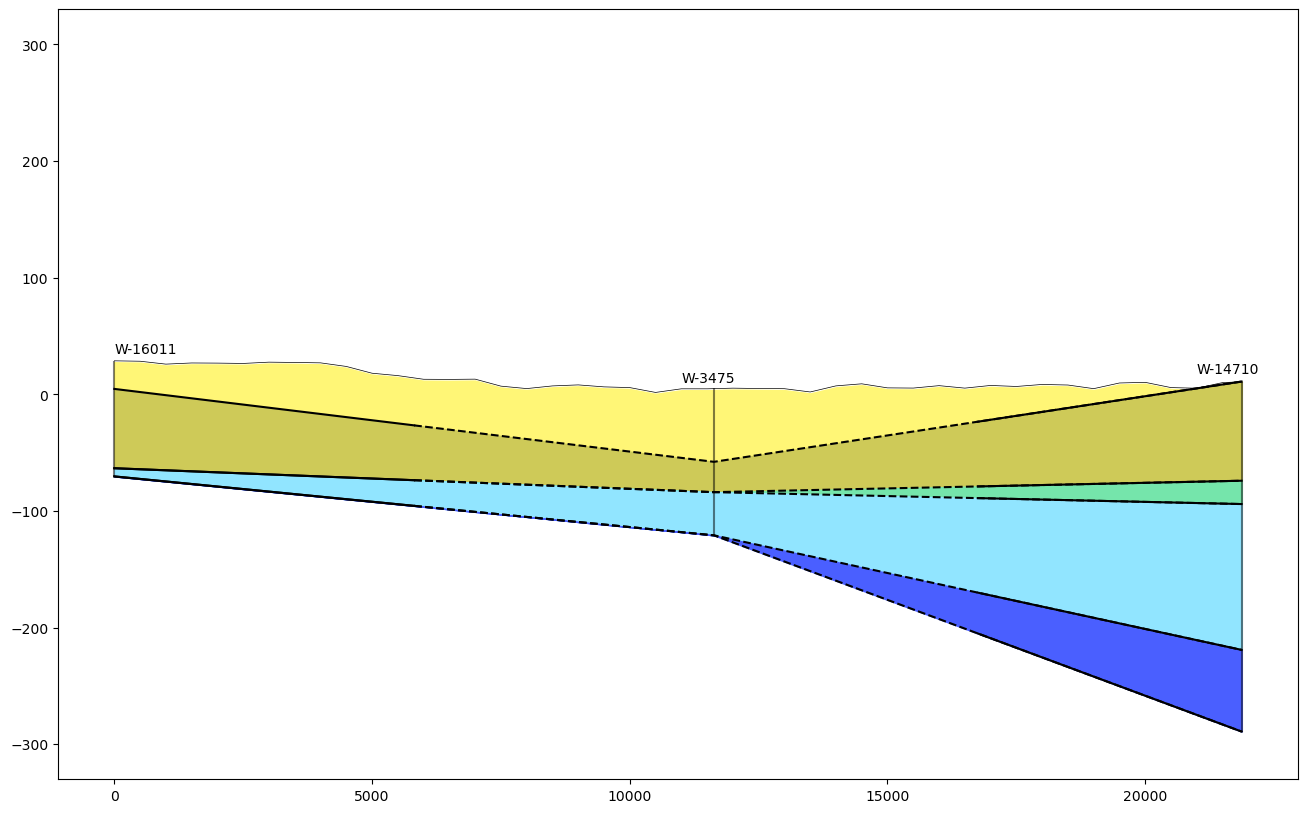

In [29]:
fig, ax = plt.subplots(figsize=(16, 10))

#Plots the surface lithology with the elevation
ax.fill_between(elev_array[1], elev_array[0], color='#FFF676', zorder = 2)
ax.fill_between(distance, elevations, og_formation_array[0], color='#FFF676', zorder = 2)

#Plots a white cover above elevation to cut off anuy formations that exceed the elevation 
ax.fill_between(elev_array[1], elev_array[0], 30, color='w', zorder=2)

#Plots each formation
ax.fill_between(distance, og_formation_array[0], og_formation_array[1], color='#CECA58', zorder=2)
ax.fill_between(distance, og_formation_array[1], og_formation_array[2], color='#75E5AB', zorder=2)
ax.fill_between(distance, og_formation_array[2], og_formation_array[3], color='#91E5FF', zorder=2)
ax.fill_between(distance, og_formation_array[3], og_formation_array[4], color='#4A5FFF', zorder=2)

#Plots a white bottom layer that covers any artifacts
ax.fill_between(distance, btm, -300, color='w')

#Creates the vertical lines indicating well locations
w1 = ax.vlines(0, color='k', ymin=-70.4, ymax=28.6, zorder=5)
w2 = ax.vlines(11633, color='k', ymin=-120.9, ymax=5.1, zorder=5)
w3 = ax.vlines(21870, color='k', ymin=-289.1, ymax=10.9, zorder=5)

w1.set_alpha(0.5)
w2.set_alpha(0.5)
w3.set_alpha(0.5)

#Plots a solid line on the top of the elevation 
ax.plot(elev_array[1], elev_array[0], color='k', linewidth=0.5)

#Plots dashed or solid lines for formation contacts
core_or_cut = [1,0,0,0,1]
for row in range(line_array.shape[0]):
    formation_elevations = line_array[row,:]

    dashed_solid_plot(ax, line_distance, core_or_cut, formation_elevations)

#Creates the text for well number
ax.annotate("W-16011", xy = (0, 35))
ax.annotate("W-3475", xy = (11000, 10))
ax.annotate("W-14710", xy = (21000, 18))

plt.show()

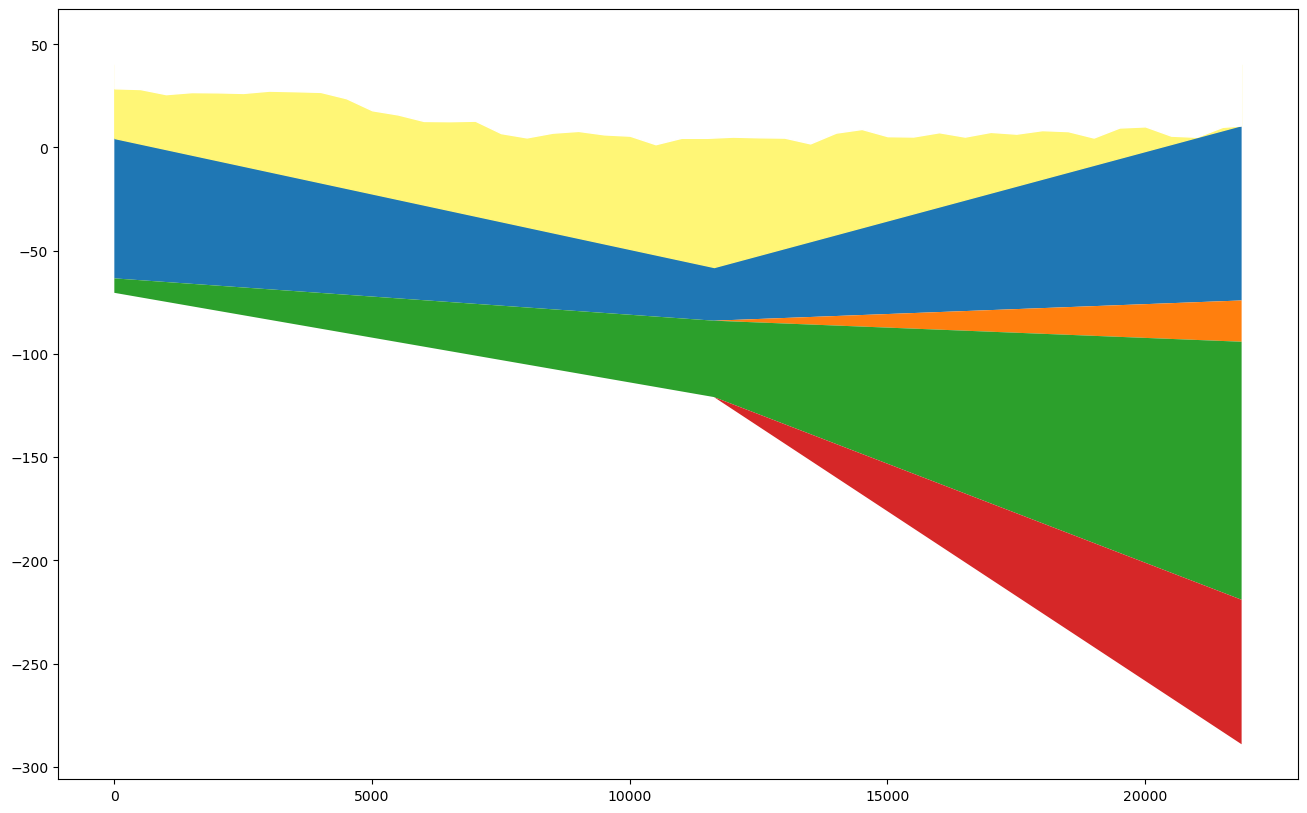

In [78]:
fig, ax = plt.subplots(figsize=(16, 10))

#Plots the surface lithology with the elevation
#ax.fill_between(elev_array[1], elev_array[0], color='#FFF676', zorder = 2)
ax.fill_between(distance,og_formation_array[0], 40, color='#FFF676', zorder = 2)

#Plots a white cover above elevation to cut off anuy formations that exceed the elevation 
ax.fill_between(elev_array[1], elev_array[0], 50, color='w', zorder=3)


ax.fill_between(new_distance, formation_array[0], formation_array[1])
ax.fill_between(new_distance, formation_array[1], formation_array[2])
ax.fill_between(new_distance, formation_array[2], formation_array[3])
ax.fill_between(new_distance, formation_array[3], formation_array[4])

plt.show()

